# Markov Chain Monte Carlo methods

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/)  for the Vatican Observatory Summer School 2023, and it is available from [github](https://github.com/VaticanObsSummerSchool2023/lectures/blob/main/IvezicJune28.ipynb).

#### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
- [Probabilistic Programming and Bayesian Methods for Hackers by Cam Davidson Pilon](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb) 

#### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

<a id='toc'></a>

## This notebook includes:

[Introduction to MCMC](#intromcmc) 

[Non-linear Regression with MCMC](#NLRmcmc) 

### Software needed

For the examples we will be using PYMC3 

- pip install git+https://github.com/pymc-devs/pymc3

To demonstrate how MCMC techniques sample we will use Jake Vanderplas's animation code
- pip install JSAnimation

Aside: PYMC3 should install Theano (a deep learning package) by default as it is used in manny of the definitions of distributions. We will call Theano a couple of times in the later exercises

### Testing it all works 

If you want to ensure that you have everything in place try to run the following piece of code (we will walk through what these lines mean as we go through the class). You should see something like the following figure

<center><img src="figures/pymc3-gaussian.png" alt="pymc3 test" style="width:600px;"/></center>



In [1]:
pip install JSAnimation

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, cauchy
import scipy.stats as stats  

from JSAnimation import IPython_display
import pymc3 as pm
import theano as thea
import theano.tensor as T 
%matplotlib inline

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.985,0.139,9.728,10.249,0.001,0.001,37946.0,27682.0,1.0
sigma,1.964,0.100,1.778,2.151,0.001,0.000,37510.0,28671.0,1.0


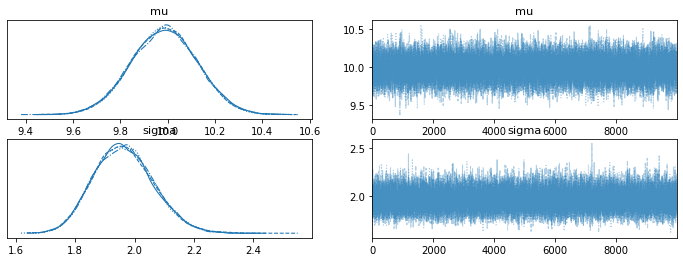

In [3]:
# generate a set of data: N points from a normal (Gaussian) distribution
N = 200
mu_0 = 10.
sigma_0 = 2.
y = np.random.normal(loc=mu_0, scale=sigma_0, size=N)

# run MCMC
nsamples = 10000
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=-20, upper=20)     # a simple uniform prior
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    y_obs = pm.Normal('Y_obs', mu, sigma, observed=y) # we use the canned distributions in PYMC3
   
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    
    trace = pm.sample(nsamples, step, start, random_seed=123, progressbar=True)

    lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines= lines)
pm.summary(trace)

**traceplot** provides
- marginal posterior distribution for each parameter (left)
- the timeseries of the parameter values from the chain (right)

Right hand side shows broad oscillation: both inlying and extreme values occur frequently but at irregular intervals indicating the markov sampler chain was 'well-mixed' (sampling evenly around the optimal position)



##  Introduction to MCMC<a id='intromcmc'></a>
[Go to top](#toc)

### Here MCMC stands for Markov Chain Monte Carlo

In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps are included, the more closely the distribution of the sample matches the actual desired distribution. Various algorithms exist for constructing chains, including the Metropolis–Hastings algorithm. For more details,
see Chapter 5 in the textbook and 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)


Monte Carlo is a city in Europe, in the Principality of Monaco (of Grace Kelly fame)... and they are known for gambling. A family of random sampling methods was named after Monte Carlo in order to keep the method secret (because it was invented and used for nuclear weapons design in the U.S. around and after World War II). With the advent of computers, Monte Carlo methods, such as Monte Carlo integration and Monte Carlo statistical tests, became hugely important.


![monaco](figures/monacoMap.jpg)
![monaco](figures/montecarlophoto.jpg)





### Reminder:

**The Bayesian Statistical Inference process** is:
* formulate the likelihood, $p(D\,|\,M,\theta,I)$
* chose a prior $p(M,\theta\,|\,I)$, which incorporates *other information beyond the data in $D$*
* determine the posterior pdf, $p(M,\theta \,|\,D,I)$
* search for the model parameters that maximize $p(M,\theta \,|\,D,I)$ 
* quantify the uncertainty of the model parameter estimates (credible region)
 

### Definition of the general problem

**To find the maximum of a multi-dimensional function (e.g. likelihood or Bayesian posterior pdf)
we need a better method than the brute force grid search!**

For example, if we could generate a **sample** of  {𝜇𝑖,𝜎𝑖}  drawn from the posterior pdf for  𝜇  and  𝜎 , we could simply get posterior pdf for  𝜇  and  𝜎  by plotting histograms of  𝜇  and  𝜎  (similar to the above figure). As simple as that!

But how can we get such samples? **By using computers!** And MCMC :)

First we'll say a few words about Monte Carlo in general, and then we'll talk about a special kind of Monte Carlo called Markov Chain Monte Carlo.

What we want to be able to do is to evaluate multi-dimensional 
($\theta$ is a k-dimensional vector) integrals of the form 
$$ I = \int g(\theta) \, p(\theta) \, d\theta,$$
where for simplicity posterior pdf is described as
$$ p(\theta) \equiv p(M,\theta \,|\,D,I) \propto p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I). $$

For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the sought
after model parameters, and the next $k-P$ parameters are nuisance 
parameters, when marginalizing $p(\theta)$ over nuisance parameters
we have $g(\theta) = 1$ and we integrate over space spanned by $k-P$ 
nuisance parameters. 

2) **Point estimates** for the posterior: if we want the mean of a model
parameter $\theta_m$, then $g(\theta) = \theta_m$ and we integrate over
all model parameters. 

3) **Model comparison**: here $g(\theta) = 1$ and we integrate over all model
parameters. 

## Monte Carlo Methods 

What you need is a computer that can generate (pseudo)random numbers and then you
solve a lot of hard problems. Let' start with an easy problem of one-dimensional
numerical integration.

Assume that you can generate a distribution of M random numbers $\theta_j$ uniformly sampled 
within the integration volume V. Then our interval can be evaluated as 
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{V}{M} \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$
    
Note that in 1-D we can write a similar expression 
$$ I = \int f(\theta) \, d\theta = \Delta \, \sum_{j=1}^M g(\theta_j) \, p(\theta_j).$$

where $ f(\theta) = g(\theta) \, p(\theta) $, and it is assumed that the values
$\theta_j$ are sampled on a regular grid with the step $\Delta = V/M$ ($V$ here is the
length of the sampling domain). This expression is the simplest example of
numerical integration ("rectangle rule", which amounts to approximating $f(\theta)$
by a piecewise constant function).

The reason why we expressed $f(\theta)$
as a product of $g(\theta)$ and $p(\theta)$ is that, as we will see shortly,
we can generate a sample drawn from $p(\theta)$ (instead of sampling on a 
regular grid), and this greatly improves the performance of numerical integration.

### A simple example: numerical integration with Monte Carlo

One of the simplest numerical integration methods is generic Monte Carlo. We generate a random set of  M values  $\theta$,  uniformly sampled within the integration volume  $V(\theta)$ as ${ I \approx { V\theta \over M} \sum{j=1}^M g(\theta_j) \, p(\theta_j). }$ This method is very inefficient when the integrated function greatly varies within the integration volume, as is the case for the posterior pdf. This problem is especially acute with high-dimensional integrals.

fractional integration error for pi:
M:  10 0.1459155902616465 0.3369015219719209
M:  100 0.018591635788130244 0.04507034144862795
M:  1000 0.022411354422335737 0.01260273305788134
M:  6000 0.005222620568410954 0.009997268861167854
M:  500000 0.0004662137174657882 3.96784699794002e-05


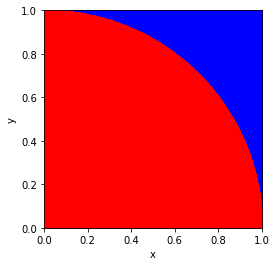

In [4]:
print ("fractional integration error for pi:")
for M in [10, 100, 1000, 6000, 500000]:
    x = stats.uniform(0, 1).rvs(M)
    y = stats.uniform(0, 1).rvs(M)
    z = stats.uniform(0, 1).rvs(M)
    
    r2 = x*x+y*y
    r3 = x*x+y*y+z*z

    print ('M: ', M, np.abs((np.pi-4.0*np.size(x[r2<1])/M)/np.pi), np.abs((np.pi-6.*np.size(x[r3<1])/M))/np.pi)

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
plt.plot(x, y, '.k', markersize=3, c='blue')
plt.plot(x[r2<1], y[r2<1], '.k', markersize=3, c='red')
ax.axis([0, 1, 0, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

##  Markov Chain Monte Carlo

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 


A number of methods exist that are much more efficient than generic Monte Carlo integration. 
The most popular group of techniques is known as Markov Chain Monte Carlo (MCMC) . 

MCMC returns a sample of points, or **chain**, from the k-dimensional parameter space, with 
a distribution that is **asymptotically proportional** to $p(\theta)$. The constant of 
proportionality is not important in the first class of problems listed above. In model 
comparison problems, the proportionality constant must be known and we will return to this 
point later.


Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.


### What is a Markov process or chain?

A Markov process is defined as a sequence of random variables where a parameter depends 
*only* on the preceding value.  Such processes are "memoryless".  
 
Mathematically, we have
$$p(\theta_{i+1}|\{\theta_i\}) = p(\theta_{i+1}|\,\theta_i).$$


Think of $\theta$ as a vector in multidimensional space, and a realization of the chain represents a path through this space. 

For  equilibrium, or a stationary distribution of positions, it is necessary that the transition probability is symmetric:
$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$


This is called the detailed balance or reversibility condition (i.e. the probability of a jump between two points does not depend on the direction of the jump).


The use of resulting chains to perform Monte Carlo integration is called Markov Chain Monte Carlo (MCMC).
Given such a chain of length M, the integral can be estimated as
$$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{j=1}^M g(\theta_j).$$

Again, here **the values of $\theta$ are not sampled uniformly from the volume**;
they are sampled **proportionally** to $p(\theta)$! Note that there is no $p(\theta_j)$ 
term next to $g(\theta_j)$ because the proper weighting in the sum is taken care of 
by the sample itself! 

As a simple example, to estimate the expectation value for $\theta_1$ (i.e., $g(\theta)=\theta_1$),
we simply take the mean value of all $\theta_1$ in the chain.

Given a Markov chain, quantitative description of the posterior pdf
becomes a density estimation problem. To visualize the posterior pdf
for parameter $\theta_1$, marginalized over all other parameters, $\theta_2, \ldots, \theta_k$,
we can construct a histogram of all $\theta_1$ values in the chain, and normalize its integral
to 1. To get a MAP (maximum a posterori) estimate for $\theta_1$, we  find the maximum of this marginalized pdf.

In order for a Markov chain to reach a stationary distribution proportional to $p(\theta)$,
the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,
$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$
where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the jump kernel or
transition kernel (and it is assumed that we know how to compute $p(\theta_i)$).

This requirement will be satisfied when the transition probability satisfies the detailed
balance condition
$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$




##  Markov Chain Monte Carlo

How do we build the chain? Need to choose how far we will be allowed to move at each step. Need to decide whether we will accept the move (e.g. of $p(\theta_{i+1})$ is smaller)

*Various MCMC algorithms differ in their choice of transition kernel*

The most classic approach is the **The Metropolis-Hastings algorithm** 

**The Metropolis-Hastings algorithm** adopts acceptance probability
$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$
where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $K(\theta_{i+1}\,|\,\theta_i)$. A Gaussian distribution centered on 
$\theta_i$ is often used for $K(\theta_{i+1}|\theta_i)$.

** When $\theta_{i+1}$ is rejected, $\theta_i$ is added to the chain instead. **

The original Metropolis algorithm is based on a symmetric proposal distribution,
$K(\theta_{i+1}|\theta_i) =  K(\theta_i|\theta_{i+1})$, which then cancels out from
the acceptance probability. **In this case, $\theta_{i+1}$ is always accepted if
$p(\theta_{i+1}) > p(\theta_i)$, and if not, then it is accepted with a probability
$p(\theta_{i+1})/p(\theta_i)$.**

**The key aspect** is that

$\frac{p(M,\theta_{i+1} \,|\,D,I)}{p(M,\theta_{i} \,|\,D,I)} = \frac{\frac{p(D\,|\,M,\theta_{i+1},I)\,p(M,\theta_{i+1},|\,I)}{p(D\,|\,I)}}{\frac{p(D\,|\,M,\theta_i,I)\,p(M,\theta_i\,|\,I)}{p(D\,|\,I)}} = \frac{p(D\,|\,M,\theta_{i+1},I)\,p(M,\theta_{i+1},|\,I)}{p(D\,|\,M,\theta_i,I)\,p(M,\theta_i\,|\,I)}
$

so there is no dependence on the evidence $p(D\,|I)$. 

This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

##  Markov Chain Monte Carlo

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1) given $\theta_i$ and $K(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 

2) compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.

3) draw a random number between 0 and 1 from a uniform distribution; if it is smaller than
   $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$.
   
4) if $\theta_{i+1}$ is accepted added it to the chain, if not, add $\theta_{i}$ to the chain.

5) use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is
  an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for 
  $\theta$ can be computed from 
  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{M} \sum_{j=1}^M \theta_j.$$

where M is the number of elements in the chain (e.g. 
the expectation value for $\theta$ is simply the mean value of chain elements). Again, this is **much more efficient** numerical method than standrd numerical intergration on a regular grid! 
  
  

### A simple example

Before looking at the  Metropolis-Hastings algorithm in more detail, let's
look at the simplest example of MCMC I could think of:
- there are only 10 possible states (think of digits 0-9)
- we are given the target probabilities for these states (frequency of each digit): $t_0, t_1..., t_9$.
- we want to generate a sample of N digit values, $n_0, n_1,...,n_9$, whose distribution 
   $p_i = n_i/\Sigma n$ (n.b. $ \Sigma n = N$) approaches the target distribution $t$ (that is, 
   $p_0 \approx t_0$, $p_1 \approx t_1$, etc). In other words, 
   we want the histogram of that sample to have the same shape as the target distribution.
- for simplicity, we draw the next digit randomly and uniformly from all 10 possibilities
- if we accept all the new proposed digits, we'll end up with a uniform distribution (because
  that's how we are drawing the new values)
- hence, **the key is to reject some proposed digits so that the remaining ones resemble the desired
  target distribution**

<img src="figures/digits.tiff" alt="Drawing" style="width: 600px;"/>

The last condition, accepting B with a probability $T(B|A)=p(B)/p(A)$, **guarantees**
that we will eventually arrive to a stationary distribution, and that distribution 
will converge to the input desired distribution. 
  

Before going to the 10-states example, let's consider for a moment **a two-state example,
with states A and B**. It would be a stretch to call it an MCMC example, but it does
address one of the key aspects of MCMC: how to set the rejection (or acceptance)
probability for a new "proposal".

Let's assume that the target probabilities are $t(A)$ and $t(B)$, with $t(A) > t(B)$ 
without a loss of generality (and of course $t(A) + t(B)=1$). Say, $t(A)=0.9$ and
$t(B)=0.1$. We want a sample of $N$ values that can be either A or B, with $t(A)N$ 
in state A and $t(B)N$ in stateB.

We begin by drawing a sample of $N$, say $N=1000$, random values that can be either 
A or B. We expect that we will have about N/2 values of A and about N/2 values of B. 
This is **not** what we want! (we want to have 900 A values and 100 B values, not
500 and 500). Therefore, we need to ** take a fraction of proposed B values and
re-assign them to A** (in other words, *reject* them from the proposed B subset). 
How do we choose them? 

In a steady state described by the target probabilities, we expect that out of N/2 
proposed B values, about $t(A)N/2$ were drawn when the system was in A state, and 
about $t(B)N/2$ when the system was in B state. Hence, in the former case the system 
is in the more probable A state and the proposal is to move to the less probable B state. 
Again, if we accept all proposals, we will not end up with the desired distribution. 
Instead, we need to **reject** a fraction $x_A$ of these $t(A)N/2$ proposals to adopt 
(the less probable) B state and thus accept (stick with) $x_At(A)N/2$ current A states. 

As a result, we will have a total of $\left(N/2 + x_At(A)N/2\right)$ A states, and we want it 
to be equal to $t(A)N$. Therefore, we have a condition for the rejection fraction $x_A$:
$$ \frac{N}{2} + x_A\,t(A)\,\frac{N}{2} = t(A)\,N.$$
The solution for the rejection fraction is $x_A = 1 - t(B)/t(A)$, and thus the 
acceptance probability in cases when the proposal is to go from state A to state B
must be 
$$p_{acc}(B|A) =  t(B)/t(A).$$ 
In all other cases (A proposed to go to A, and B proposed
to go to either state), the proposal is always accepted. 

In summary, **the acceptance probability** for the two-state system is 

1) in A, proposed to go to A: accept

2) in A, proposed to go to B: accept in p(B)/p(A) cases

3) in B, proposed to go to A: accept

4) in B, proposed to go to B: accept 


Let's now do the 10-state example!  

In [5]:
printStep = 50
i = 49
if (int(i/printStep)*printStep == i):
    print('yes')

In [6]:
def doSimpleMCMC(pi, priorIndex, Niter, printStep, plot = 0):
 
    # starting states 
    states = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    states[priorIndex] += 1
    Nreject = 0

    for i in range(0, Niter):
        ## get index for the proposed new state: completely random from 10 states 
        newind = np.random.randint(low=0, high=10) # a number between 0 and 9 (inclusive) 
        # MCMC rules:
        # if a uniform variate 0-1 larger than pi[newind]/pi[priorIndex], reject proposed newind
        # and otherwise accept it 
        reject = 0
        if (np.random.uniform() > pi[newind]/pi[priorIndex]):
            reject = 1
        if (reject):    
            states[priorIndex] += 1
            Nreject += 1
        else:
            states[newind] += 1
            priorIndex = newind
        if (int(i/printStep)*printStep == i):
            prob = 1.0*states / np.sum(states)
            for j in range(0,np.size(prob)):
                prob[j] = float("{0:.2f}".format(prob[j]))  
            print('i=',i,' p=', prob)

    print('      pi', pi)
    print('')
    print('Tried ', Niter, 'and rejected ', Nreject)

    if (plot):
        plotP(pi, states)

    return states

def plotP(pi,states):
    prob = 1.0*states / np.sum(states)

    # plot
    fig, ax = plt.subplots(figsize=(7, 5))

    N = np.size(pi)
    for i in range(0,N):
        plt.plot([i,i+1],[prob[i],prob[i]], c='red')
        plt.plot([i,i+1],[pi[i],pi[i]], '-', c='blue')            
        if (i < (N-1)):
            plt.plot([i+1,i+1],[prob[i],prob[i+1]], c='red')
            plt.plot([i+1,i+1],[pi[i],pi[i+1]], '-', c='blue')

    plt.xlim(0, 10)
    ymax = 1.1*np.max(pi)
    if (np.max(prob)>np.max(pi)):
        ymax = 1.1*np.max(prob)
    plt.ylim(0, ymax)
    plt.xlabel('$N$')
    plt.ylabel(r'$p(N)$')
    plt.title('red: MCMC, blue: target')
    plt.show() 

i= 0  p= [0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0. ]
i= 5  p= [0.14 0.14 0.   0.14 0.   0.29 0.   0.14 0.14 0.  ]
      pi [0.05, 0.1, 0.18, 0.32, 0.15, 0.05, 0.05, 0.02, 0.05, 0.03]

Tried  10 and rejected  0


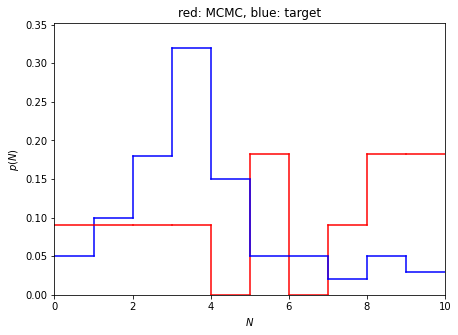

In [7]:
# target distribution for 9 states 
pi = [0.05, 0.10, 0.18, 0.32, 0.15, 0.05, 0.05, 0.02, 0.05, 0.03]
startIndex = 0
Niter = 10
printStep = 1

# states = doSimpleMCMC(pi, startIndex, Niter, printStep)
states = doSimpleMCMC(pi, startIndex, 10, 5, 1)

i= 0  p= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
i= 50  p= [0.08 0.08 0.12 0.5  0.15 0.02 0.04 0.   0.02 0.  ]
      pi [0.05, 0.1, 0.18, 0.32, 0.15, 0.05, 0.05, 0.02, 0.05, 0.03]

Tried  100 and rejected  48


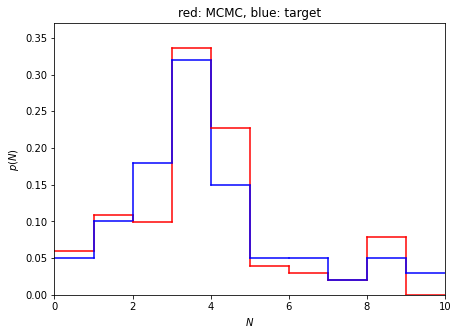

In [8]:
states = doSimpleMCMC(pi, startIndex, 100, 50, 1)

i= 0  p= [0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
i= 5000  p= [0.05 0.11 0.18 0.32 0.15 0.05 0.05 0.02 0.05 0.03]
      pi [0.05, 0.1, 0.18, 0.32, 0.15, 0.05, 0.05, 0.02, 0.05, 0.03]

Tried  10000 and rejected  4408


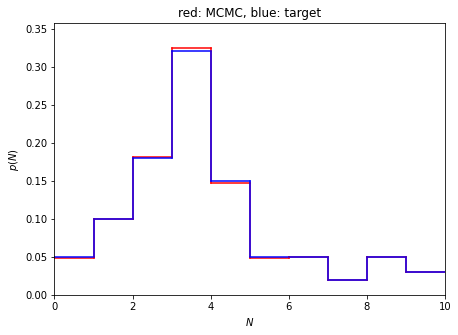

In [9]:
states = doSimpleMCMC(pi, startIndex, 10000, 5000, 1)

### Illustrate Metropolis-Hastings algorithm 

In [10]:
np.random.seed(21)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data)*Prior(x)

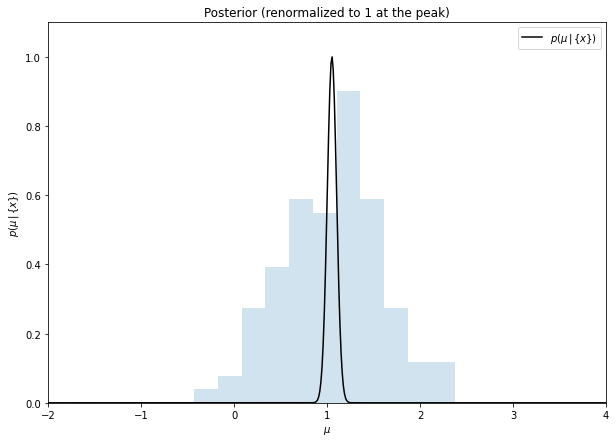

NOTE: Ndata= 100 sigmaData= 0.5 so sigma_mu= 0.05


In [11]:
## generate data
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

# plot likelihood function 
muMin = mu - 6*sigma
muMax = mu + 6*sigma
muGrid = np.linspace(muMin, muMax, 500)
posterior = 0*muGrid

for j in range(0,np.size(muGrid)):
    posterior[j] = myPosterior(muGrid[j], sigma, data)

posteriorNorm = posterior/np.max(posterior)
# plot
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(muGrid, posteriorNorm, ls='-', c='black', label=r'$p(\mu\,|\,\{x\})$')
plt.hist(data, bins = 'auto', density=True, histtype = 'stepfilled', alpha=0.2)

plt.xlim(muMin, muMax)
plt.ylim(0, 1.1)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(\mu\,|\,\{x\})$')
plt.title('Posterior (renormalized to 1 at the peak)')
plt.legend()
plt.show() 

sigMu = sigma/np.sqrt(Ndata)
print('NOTE: Ndata=', Ndata, 'sigmaData=', sigma, 'so sigma_mu=', sigMu)

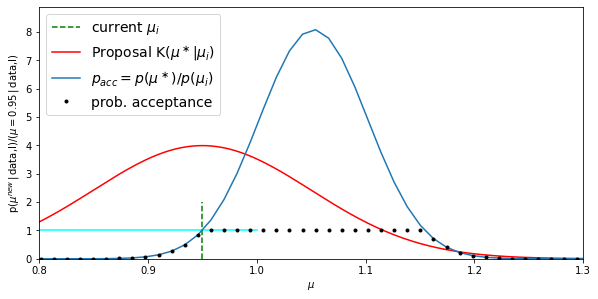

NOTE: we accept if a uniform random number (0-1) falls below the black dotted curve.


In [12]:
## illustrate Metropolis-Hastings algorithm 
muStart = 0.95
posteriorStart = myPosterior(muStart, sigma, data)
pRatio = posterior/posteriorStart

# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)
ax0 = fig.add_subplot(111)
ax0.axis([0.8, 1.3, 0, 1.1*np.max(pRatio)])
plt.xlabel('$\mu$')
plt.ylabel('p($\mu^{new}\,|\,$data,I)/($\mu=0.95\,|\,$data,I)')
plt.plot([0.8,1.0],[1.0,1.0], '-', c='cyan')
plt.plot([0.95,0.95],[0.0,2.0], '--', c='green', label=r'current $\mu_i$')

# plot proposal distribution
muG = np.linspace(0.0, 2.0,500)
sigmaProp = 0.1
prop = norm(muStart, sigmaProp).pdf(muG) 
plt.plot(muG, prop, c='red', label=r'Proposal K($\mu^\ast|\mu_{i}$)')
plt.plot(muGrid, pRatio, label=r'$p_{acc}=p(\mu^\ast)/p(\mu_i)$')
plt.plot(muGrid[pRatio<1], pRatio[pRatio<1], '.', c='black',label=r'prob. acceptance')
plt.plot(muGrid[pRatio>1], 1+0*muGrid[pRatio>1], '.', c='black')
ax0.legend(loc=2, prop=dict(size=14))
plt.show() 

print('NOTE: we accept if a uniform random number (0-1) falls below the black dotted curve.')

In [13]:
## generate a chain using Metropolis-Hastings algorithm 

# Markov chain 
M = 5000  # the requested number of steps in the chain
chain = np.linspace(0,1,M)
chain[0] = 0.5 # starting position
Pold = myPosterior(chain[0], sigma, data)

# gaussian width for "jumping" from the current position
#    sigmaProp            Na   Nr   Np     
# sigmaProp = 0.03    #  3992 1007 1968   (high acc, long burn-in) 
# sigmaProp = 0.3     #  1043 3956  534   (low acc, short burn-in) 
sigmaProp = 0.10      #  2514 2485 1248        

Na = Nr = Np = 0
# and now sample M times
for i in range(1,M):
    # 1) generate a new value: a gaussian jump from current value
    Cold = chain[i-1]
    Cnew = stats.norm(Cold, sigmaProp).rvs(1)
    Pnew = myPosterior(Cnew, sigma, data)
    # 2) acceptance condition 
    Pratio = Pnew / Pold  
    if (Pratio > 1): 
        Np += 1   # just a counter, nothing else is done 
    # if we only accept Pratio>1, we'll get a hill-climbing algorithm
    # instead, we'll randomly accept this proposal with probability Pratio 
    randNumber = stats.uniform(0, 1).rvs(1)
    if (randNumber < Pratio):
        # accepting this new proposed value
        chain[i] = Cnew
        Pold = Pnew
        Na += 1
    else:
        # rejecting the proposed value and stickin' with the previous one 
        chain[i] = Cold
        Nr += 1
 
print('NNN(arp): ', Na, Nr, Np)

NNN(arp):  2514 2485 1248


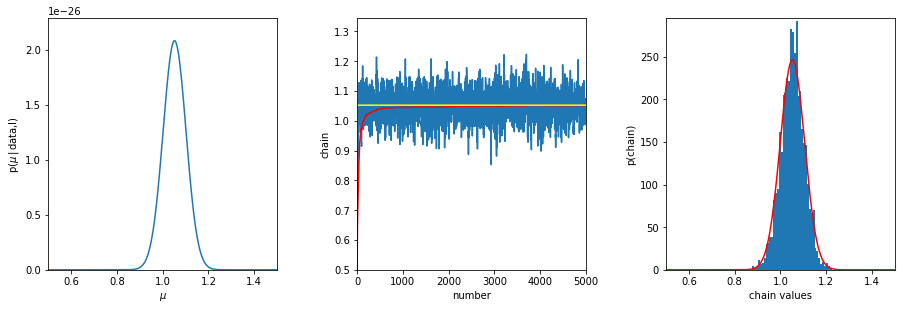

µ=1.052, 𝜎=0.053


In [14]:
# start plot 
fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax0 = fig.add_subplot(131)
muGrid = np.linspace(mu-sigma,mu+sigma,500)
posterior = 0*muGrid
for j in range(0,np.size(muGrid)):
    posterior[j] = myPosterior(muGrid[j], sigma, data)
plt.plot(muGrid, posterior)
ax0.axis([mu-sigma, mu+sigma, 0, 1.1*np.max(posterior)])
plt.xlabel('$\mu$')
plt.ylabel('p($\mu\,|\,$data,I)')

ax1 = fig.add_subplot(132)
x = np.linspace(1,M,M)
plt.plot(x, chain)
ax1.axis([0, M, np.min(chain), 1.1*np.max(chain)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chain[:int(N)]) for N in x]
ax1.plot(x, meanC,c='red') 
ax1.plot(x, 0*x+np.mean(data),c='yellow') 

ax2 = fig.add_subplot(133)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chain[x>Nburn])
Nhist, bins, patches = plt.hist(chain[x>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(mu-sigma,mu+sigma,500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(mu-sigma, mu+sigma)
ax2.set_ylim(0, 1.2*np.max(gauss))

plt.show()
print(f"µ={muCLT:.3f}, 𝜎={sigCLT:.3f}")

## Caveats

Although $K(\theta_{i+1}|\theta_i)$ satisfies a Markov chain requirement that it
must be a function of only the current position $\theta_i$, it takes a number
of steps to reach a stationary distribution from an initial arbitrary position $\theta_0$.
**These early steps are called the "burn-in" and need to be discarded in analysis.**
There is no general theory for finding transition from the burn-in phase to
the stationary phase; several methods are used in practice. Gelman and Rubin
proposed to generate a number of chains and then compare the ratio of
the variance between the chains to the mean variance within the chains (this
ratio is known as the $R$ statistic). For stationary chains, this ratio will
be close to 1.  

When the posterior pdf is multimodal, the simple Metropolis--Hastings algorithm can
become stuck in a local mode and not find the globally best mode within a reasonable
running time. There are a number of better algorithms, such as Gibbs sampling, parallel
tempering, various genetic algorithms, and nested sampling.



<img src="figures/Andrieu4.tiff" alt="Drawing" style="width: 600px;"/>





### How do we choose the next step

How far should we step (small steps in parameter space or large). This impacts the efficiency of the process but not if we will reach equilibrium. We want our samples to be independent of one another which we can determine with the autocorrelation function - we can then adjust the step size to account for this (e.g. ensure that we reject 50% of the proposed steps)

Other techniques: **NUTS (No-U-Turn Sampler)**, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis

[NUTS](http://arxiv.org/abs/1507.08050) is generally the sampler of choice for continuous parameters (it uses  the gradient of the log posterior-density). See the end of this notebook for animations of different strategies 



In [15]:
from IPython.display import HTML
HTML('<iframe src="https://player.vimeo.com/video/19274900" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274900">Metropolis in the Square</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')

##  Non-linear Regression with MCMC<a id='NLRmcmc'></a>
[Go to top](#toc)

### Non-linear regression: when the likelihood function is not a linear function of model parameters.  

### Example of non-linear regression: the age-color relation for asteroids

We will use age and color data for asteroid families shown in figure 1 from the paper 
"An age–colour relationship for main-belt S-complex asteroids" by Jedicke et al. (2004, Nature 429, 275), see 
http://www.astro.washington.edu/users/ivezic/Publications/jedicke.pdf

Given their y(x) data (see below), with errors in both x and y, we want to fit the following function

$$ 𝑦(𝑥)=𝑎+𝑏∗[1−𝑒𝑥𝑝(−(𝑥/𝑐)^𝑑)]. $$

We have a case of non-linear regression because y(x) depends non-linearly on the 
unknown coefficients c and d.
 
Important: here x is time, not log(time)! But in plots we'll use log(time) for x axis.

We want to: 

a) find the best-fit values and standard errors for parameters a, b, c and d. 

b) show the marginal distributions of fitted parameters. 

c) compare our best fit to the best fit from Jedicke et al.  



In [16]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt 
# random seed 
np.random.seed(42)

In [17]:
# These age and color data for asteroid families are taken
# from the paper Jedicke et al. (2004, Nature 429, 275) 

# Age is measured in 10^6 yrs (Myr)
# Log10(age) and error (of Log(Age))
logAge = np.asarray([3.398, 2.477, 3.398, 3.477, 3.301, 1.699, 2.699, 0.763,
         2.301, 3.079,  3.176, 0.398])
LageErr = np.asarray([0.087, 0.145, 0.174, 0.145, 0.109, 0.347, 0.174, 0.015,
          0.217, 0.145, 0.145, 0.434])
# SDSS principal asteroid color PC1 and its error (per family)
PC1 = np.asarray([0.620, 0.476, 0.523, 0.582, 0.460, 0.479, 0.432, 0.351, 
       0.427, 0.522, 0.532, 0.311])
PC1err = np.asarray([0.005, 0.015, 0.007, 0.011, 0.005, 0.032, 0.033, 0.047,
        0.021, 0.015, 0.022, 0.027])
# time/age on linear axes
age = 10**logAge
# and standard error propagation (although errors can be large)
ageErr = age * LageErr * np.log(10)

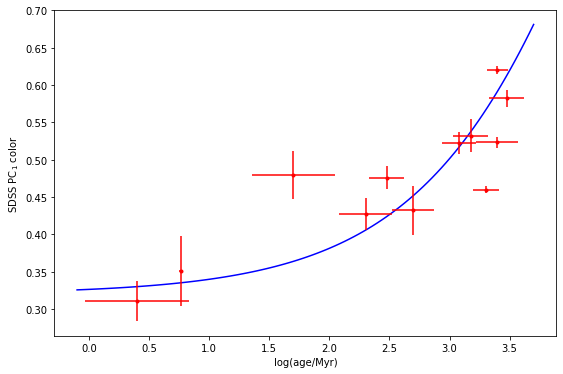

In [18]:
# let's take a quick look at the data to verify that it looks
# similar to fig. 1 from Jedicke et al. 
logT = np.linspace(-0.1, 3.7, 100)
time = np.power(10,logT)
# the best fit from Jedicke et al. 
color = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
ax = plt.figure(figsize=(9,6)).add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,color, c='blue')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', 
             marker='.', ls='None', label='Observed')
plt.show() 

#### We will use pymc3 as the tool of choice to perform MCMC, see
[pymc3 docs](https://docs.pymc.io/)


I highly recommend to peruse this 
[excellent blog post by Jake VanderPlas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

In [19]:
import pymc3 as pm
from astroML.plotting.mcmc import plot_mcmc 

In [20]:
# to make it look more generic (for future code reuse)
xObs = age
xErr = ageErr
yObs = PC1
yErr = PC1err

In [21]:
# three points to make:
# 1) note setting of the priors (for a, b, c and d)
# 2) note how error in x is handled with a latent variable
# 3) the actual model that is fit is given by AgeColor()
#      and it's super easy to change it! 
def MCMCasteroids(doXerror=True, draws=10000, tune=1000):
    with pm.Model():
        a = pm.Uniform('a', 0.1, 0.5)
        b = pm.Uniform('b', 0, 10)
        c = pm.Uniform('c', 0, 2000000)
        d = pm.Uniform('d', 0, 2)

        if doXerror:
            xLatent = pm.Normal('x', mu=xObs, sd=xErr, shape=xObs.shape)  
        else:
            xLatent = xObs
 
        y = pm.Normal('y', mu=AgeColor(xLatent, a, b, c, d), sd=yErr, observed=yObs)
        traces = pm.sample(draws=draws, tune=tune, return_inferencedata=False)

        return traces
    
# model to fit 
def AgeColor(t, a, b, c, d):
    """age-color relationship from Jedicke et al. (2004)"""
    return a + b*(1-np.exp(-(t/c)**d))

In [22]:
# obtain best-fit parameters using MCMC
traces = MCMCasteroids(True)
bf = pm.summary(traces)['mean']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, d, c, b, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 182 seconds.
There were 5837 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6520 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6551838501295986, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5459 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5624 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


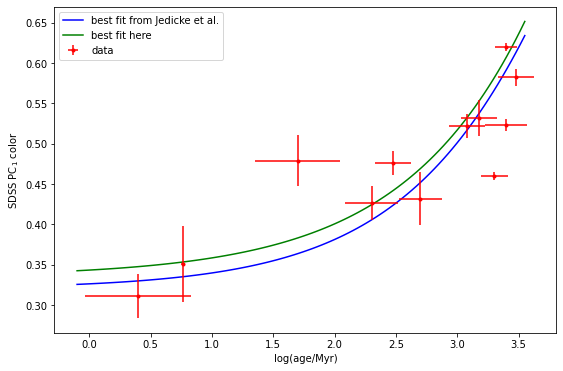

In [23]:
# let's take a look at the data and best-fit models 
logT = np.linspace(-0.1, 3.55, 100)
time = np.power(10,logT)

# fit from Jedicke
colorJedicke = 0.32 + 1.0*(1-np.exp(-(time/2.5e4)**0.5))
colorHere = AgeColor(time, bf['a'], bf['b'], bf['c'], bf['d']) 

# plot 
ax = plt.figure(figsize=(9,6)).add_subplot(111)
ax.set_xlabel("log(age/Myr)")
ax.set_ylabel("SDSS PC$_1$ color")
ax.plot(logT,colorJedicke, c='blue', label='best fit from Jedicke et al.')
ax.plot(logT,colorHere, c='green', label='best fit here')
ax.errorbar(logAge,PC1,xerr=LageErr, yerr=PC1err, color='r', marker='.', ls='None', label='data')
plt.legend()
plt.show() 

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


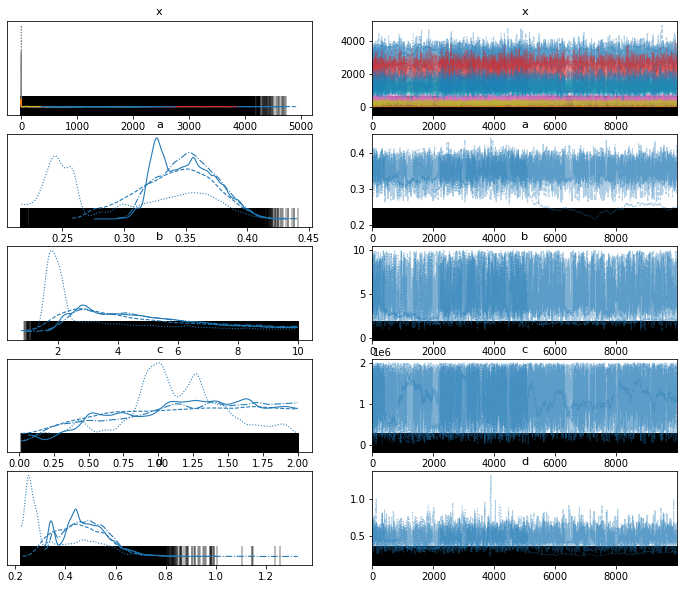

In [24]:
# the so-called traces for model parameters:
plot = pm.traceplot(traces)

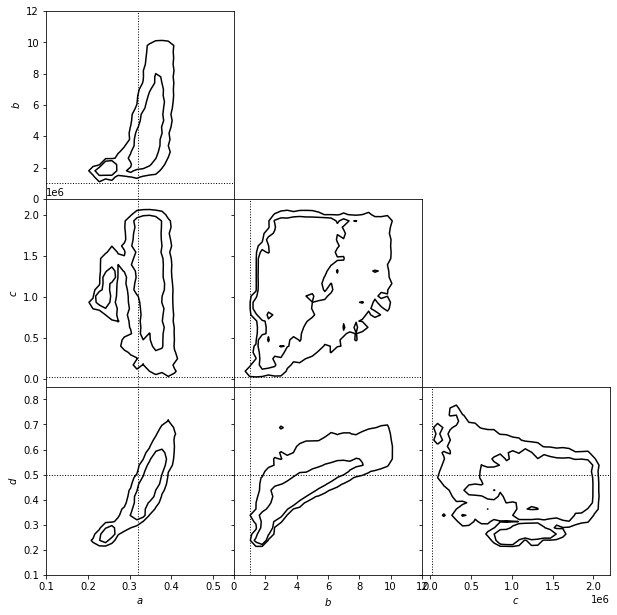

In [25]:
# and a pretty so-called corner plot:
labels = ['$a$', '$b$', '$c$', '$d$']
limits = [(0.1, 0.55), (0.0, 12), (-100000,2200000), (0.1, 0.85)]
jedicke = [0.32, 1.0, 25000, 0.5]


# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['a', 'b', 'c', 'd']],
          labels=labels, limits=limits,
          true_values=jedicke, fig=fig, bins=30, colors='k')

plt.show()

In [26]:
import corner

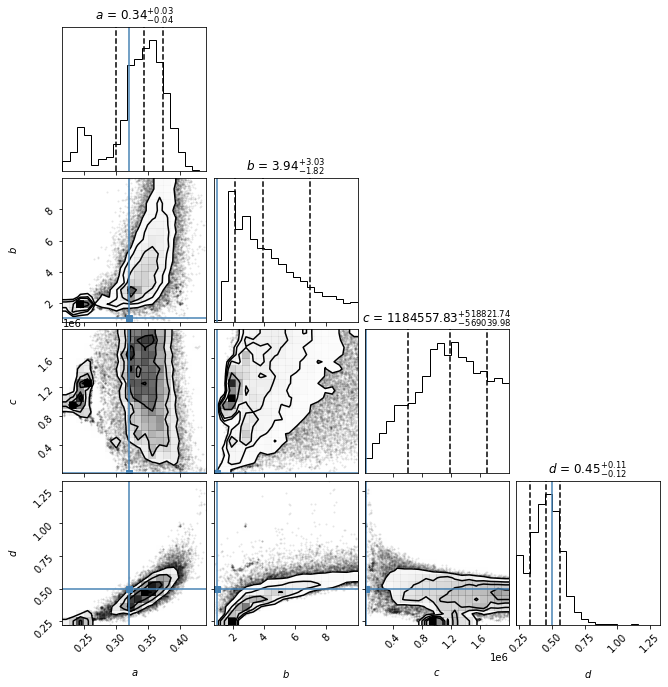

In [27]:
Ls = [r"$a$", r"$b$", r"$c$", r"$d$"] 
samples = np.vstack([traces[i] for i in ['a', 'b', 'c', 'd']]).T
corner.corner(samples, truths=jedicke, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

[Go to top](#toc)

## Modelling a weak signal on top of background


A bit of motivation: 

![particle](figures/atlas.png)

Let's assume a Gaussian profile (but this can be easily modified).

To make things interesting, we'll apply heteroscedastic observational errors -- we'll assume the measurement errors are not uniform.

Let's first generate a mock data set...

In [28]:
def GaussAndBkgd(t, b0, A, sigma, T):
    """Gaussian profile + flat background model"""
    y = b0 + A * np.exp(-(t - T)**2/2/sigma**2)
    return y

np.random.seed(42)
N = 101
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40

t = np.sort(100 * np.random.random(N))
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = (0.6+0.5*np.sin(2*np.pi*t/100)) # sinusoidal change of precision
y_obs = np.random.normal(y_true, err_y)

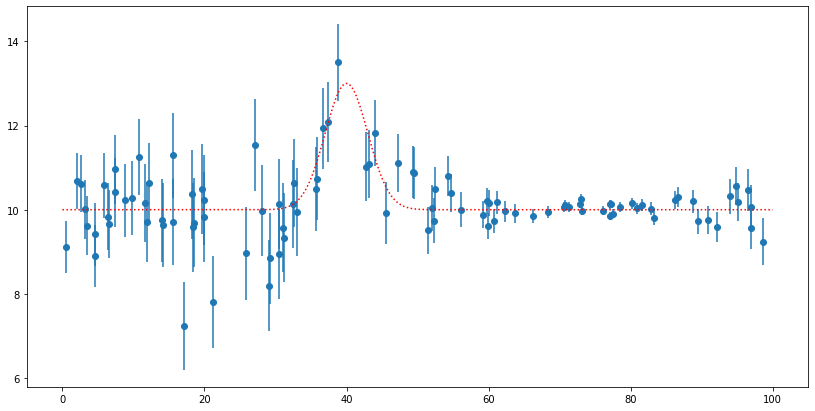

In [29]:
# and let's visualize it
plt.figure(figsize=(14, 7))

# "data" with observational errors.
plt.scatter(t, y_obs)
plt.errorbar(t, y_obs, err_y, fmt='none')

# model
tt = np.linspace(0, 100, 1000)
plt.gca().plot(tt, GaussAndBkgd(tt, b0_true, A_true, sigma_true, T_true), c='red', linestyle=':');

### now let's construct a model and sample it:

In [30]:
with pm.Model():
    b0 = pm.Uniform('b0', 5, 15)
    A = pm.Uniform('A', 0, 10)
    T = pm.Uniform('T', 35, 45)
    log_sigma = pm.Uniform('log_sigma', -1, 3)

    y = pm.Normal('y', mu=GaussAndBkgd(t, b0, A, np.exp(log_sigma), T), sd=err_y, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=40_000, tune=500, step=step, cores=1)
    print('Done')

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [log_sigma]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


Sampling 2 chains for 500 tune and 40_000 draw iterations (1_000 + 80_000 draws total) took 29 seconds.
The number of effective samples is smaller than 10% for some parameters.


Done


In [31]:
# A utility function to convert the traces (chains) to a Pandas DataFrame
import pandas as pd
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

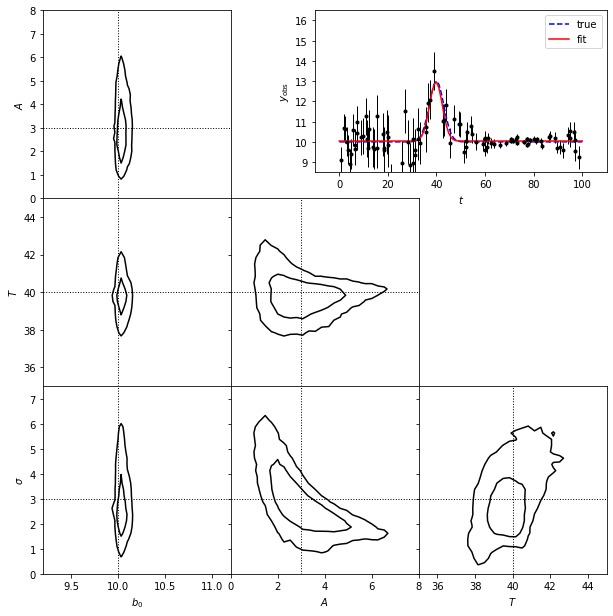

In [32]:
df = traces_to_pandas(traces, 500)
df["sigma"] = np.exp(traces['log_sigma'])
del df["log_sigma"]

variables = ['b0', 'A', 'T', 'sigma']
labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']

limits = [(9.2, 11.2), (0, 8), (35, 45), (0.0, 7.5)]
true = [b0_true, A_true, T_true, sigma_true]

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = GaussAndBkgd(t_fit, **df.median())
y_true = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, err_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='blue', label='true')
ax.plot(t_fit, y_fit, '-k', c='red', label='fit')
ax.legend()
ax.set_xlim(-10, 110)
ax.set_ylim(8.5, 16.5)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

Things to notice:
  * The fit appears reasonable. There's no indication there were issues with sampling.
  * The contours enclose $68\%$ and $95\%$ probabilities
  * Much of what's in the plot has a ready physical interpretation:
    * Note how $b_0$ is confined to a tight interval. That is because the stretch of measurements after $t > 60$, with very small error-bars, constrains it strongly.
    * Also, note how $A$ and $\sigma$ are relatively poorly constrained, but strongly correlated. You could imagine increasing $A$ to better fit the one high datapoint around $t=38$, but would have to reduce $\sigma$ (the width) so the flux falls off rapidly enough to explain the data points in the wings.

**Again, studying correlations in posterior plots can bring insight into the problem, and allow us to develop intuition about which data points constrain which model parameters the most**

[Go to top](#toc)